In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
#plots two images on the same row one representing the original image, the other reporesnt a modified image
def plt2ImagesSideBySide(image1, label1, image2, label2, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    fig = plt.figure(figsize=(20,10))
    orig = fig.add_subplot(1,2,1)
    
    if(isgray == False):
        origimgplot = plt.imshow(image1)
    else:
        origimgplot = plt.imshow(image1, cmap='gray')
    
    orig.set_title(label1)
    modif = fig.add_subplot(1,2,2)
    
    if(isgray == False):
        modifimgplot = plt.imshow(image2)
    else:
        modifimgplot = plt.imshow(image2, cmap='gray')
    modif.set_title(label2)
    
    plt.show()

def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) == len(labels)
    assert len(images) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.show()

In [3]:
def CollectImages(folderpath, ImagePaths):
    images = []
    for ImagePath in ImagePaths:
        im = mpimg.imread(folderpath + ImagePath)
        #print('This image' , ImagePath , 'is:', type(im), 'with dimensions:', im.shape)
        images.append((im, ImagePath.split('.')[0]))
        
    return images

Camera Calibration

In [4]:
def ProcessCalibImages(CalImages, boardSize):
    #Create two empty arrays to store points in distorated and undistorted image domains.
    objPts = [] # 3d points in real world space
    ImgPts = [] # 2d points in image plane.
    
    #Initialize objp to an array with index 0,0,0 -> 8,5,0
    objp = np.zeros((boardSize[0]*boardSize[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:boardSize[0], 0:boardSize[1]].T.reshape(-1, 2)
    
    for img, label in CalImages:    
        grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
        
        ret, corners = cv2.findChessboardCorners(grayImage, boardSize, None)
    
        if ret == True:
            objPts.append(objp)
            ImgPts.append(corners)
        else:
            print("Finding Calibration Image points failed for image" + label)
        
    return objPts, ImgPts

def CalculateCamMat(objPts, ImgPts, img_size):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPts, ImgPts, img_size,None,None)
    return mtx, dist

def UnDistortImage(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

Calibration Image Examples


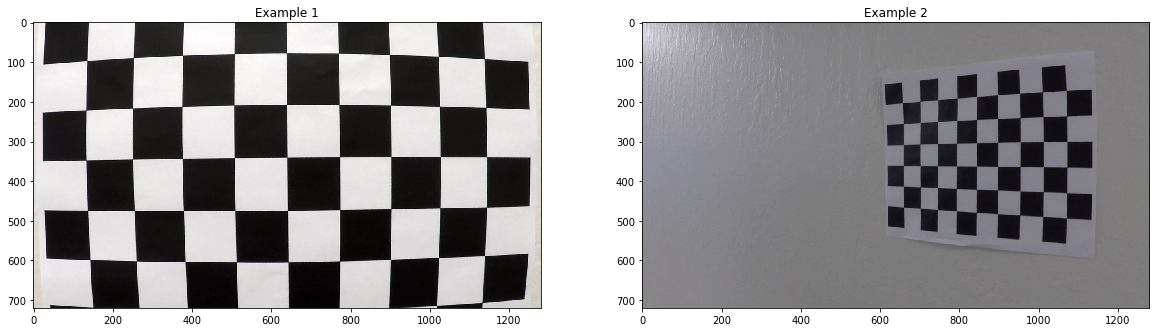

Finding Calibration Image points failed for imagecalibration1
Finding Calibration Image points failed for imagecalibration4
Finding Calibration Image points failed for imagecalibration5


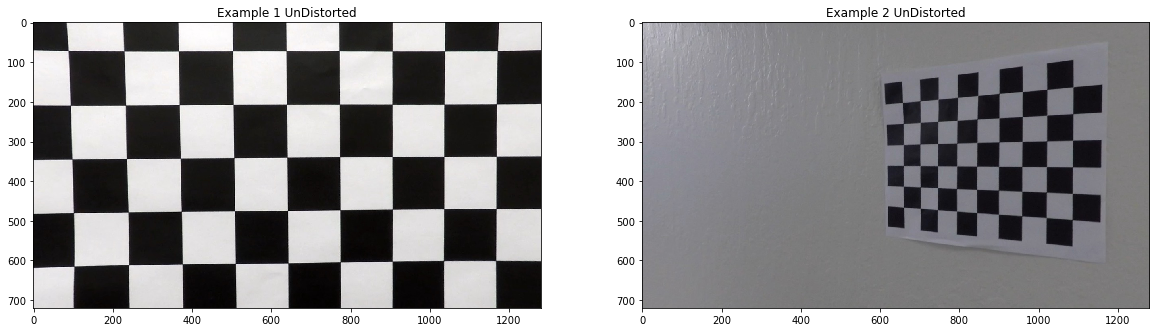

In [5]:
CamCalimagesPaths = os.listdir("camera_cal/")

CalImages = CollectImages("camera_cal/", CamCalimagesPaths)

print("Calibration Image Examples")

plt2ImagesSideBySide(CalImages[0][0], "Example 1", CalImages[3][0], "Example 2")

UndistPts, DistPts = ProcessCalibImages(CalImages, (9,6))

#All images are of same size (1280 * 720 * 3) get image size from the first one.
img_size = (CalImages[0][0].shape[1], CalImages[0][0].shape[0])

CamMtx, Dist = CalculateCamMat(UndistPts, DistPts, img_size)

Example1 = UnDistortImage(CalImages[0][0], CamMtx, Dist)
Example2 = UnDistortImage(CalImages[3][0], CamMtx, Dist)

plt2ImagesSideBySide(Example1, "Example 1 UnDistorted", Example2, "Example 2 UnDistorted")

Test PipeLine on Test Images

Color Space conversion helper functions

In [6]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def LABColorFormat(img):
    # LAB is chosen for it's robustness aganist changing lighting conditions.
    # This is due to Lightness being a seperate parameter 'L'.
    # LAB is also useful because the maximum B values represent pure yellow so yellow lane lines would be easier to detect.
    return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

Color and Spatial filtering functions

In [7]:
def filter_lanes_by_color(image):
    #convert to LAB color space
    LAB_format = LABColorFormat(image)
    
    # define range of white color in LAB color space
    lower_white = np.array([210,126,126])
    upper_white = np.array([255,137,137])

    # Threshold the LAB image to get only white colors
    white_mask = cv2.inRange(LAB_format, lower_white, upper_white)

    # define range of yellow color in LAB color space
    lower_yellow = np.array([0,0,158])
    upper_yellow = np.array([255,255,255])

    # Threshold the LAB image to get only blue colors
    yellow_mask = cv2.inRange(LAB_format, lower_yellow, upper_yellow)

    #Bitwise OR the white and yellow masks
    merged_mask = cv2.bitwise_or(white_mask, yellow_mask)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image,image, mask= merged_mask)
    return res


def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    ignore_mask_color = (255,) * img.shape[2]
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

OpenCV Wrapper Functions

In [8]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

Perform Sobel Thresholding

In [9]:
def SobelThresholding(gray_img, sobel_kernel=3, Sobel_Trheshold=(0,255,0,90)):
    #Convert from deg to rad
    low_ang_threshold  = (Sobel_Trheshold[2] / 180 * np.pi)
    high_ang_threshold = (Sobel_Trheshold[3] / 180 * np.pi)
    
    #Apply sobel gradient calculation on input
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Calculate magnitude of derivative sqrt(x'^2 + y'^2).
    sobel_mag  = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    #Scale sobel gradient magnitude to 0->255.
    scld_sobel = np.uint8( 255 * sobel_mag / np.max(sobel_mag) )
    
    #Calculate direction of magnitude of the sobel gradient.
    absgraddir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    
    #Sanity Check
    assert absgraddir.shape == sobel_mag.shape
    
    #Create blank canvas to draw on.
    binary_output =  np.zeros_like(sobel_mag)
    
    # Create masks to threshold the input image
    magnitude_mask = cv2.inRange(scld_sobel, Sobel_Trheshold[0], Sobel_Trheshold[1])
    directon_mask  = cv2.inRange(absgraddir, low_ang_threshold, high_ang_threshold)

    #Bitwise OR the white and yellow masks
    merged_mask = cv2.bitwise_or(magnitude_mask, directon_mask)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(gray_img,gray_img, mask= merged_mask)
    
    return res

Prespective Transform

In [10]:
img_h = 720
img_w = 1280

#I have tried to have a more modular approch by obtaining values using image dimensions, however non satisfactory results 
# was the output, so i had to be more aggressive by assigning constant values.
'''bottom_left  = [img_w * 0.17, img_h]
top_left     = [img_w * 0.45, img_h * 0.65]
top_right    = [img_w * 0.56, img_h * 0.65]
bottom_right = [img_w * 0.86, img_h]'''
bottom_left  = [217, 720]
top_left     = [570, 468]
top_right    = [716, 468]
bottom_right = [1100, 720]
#order bottom_left, top_left, top_right, bottom_right
src = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.float32)

'''bottom_left  = [img_w * 0.25, img_h]
top_left     = [img_w * 0.25, 0]
top_right    = [img_w * 0.72, 0]
bottom_right = [img_w * 0.72, img_h]'''

bottom_left  = [320, 720]
top_left     = [320, 0]
top_right    = [921, 0]
bottom_right = [921, 720]
#order bottom_left, top_left, top_right, bottom_right
dst = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.float32)

M = cv2.getPerspectiveTransform(src, dst)
    
MInv = cv2.getPerspectiveTransform(dst, src)

def WarpImage(img):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    warped = cv2.warpPerspective(img, M, (img_w, img_h))
    
    return warped

In [11]:
def Extract_feature_from_image(image, label, blurKS, SobelKS, SobelThrhld, verticies, pltImage = False):
    colorfilteredImage = filter_lanes_by_color(image)
    
    grayScalImage = grayscale(colorfilteredImage)
    
    blurredImage  = gaussian_blur(grayScalImage, blurKS)
    
    gradientImage = SobelThresholding(blurredImage, sobel_kernel=SobelKS, Sobel_Trheshold=SobelThrhld)
    
    gradientImage = gradientImage.reshape(image.shape[0], image.shape[1], 1)
    
    spatialFilteredImage = region_of_interest(gradientImage, verticies)
    
    WarpedImage = WarpImage(spatialFilteredImage)
    
    if pltImage == True:
        plt2ImagesSideBySide(spatialFilteredImage, label, WarpedImage, 'Processed', True)
    
    return WarpedImage

In [12]:
#This function process an image to genretae a warped, thresholded and 
#undistorted image.
def UnDistortImages(im):
    UndistortedImg = UnDistortImage(im, CamMtx, Dist)
    return UndistortedImg

In [13]:
#Code in this function inspired from https://stackoverflow.com/questions/30242898/vertical-line-in-histogram-with-pyplot 
def visualizeHistogram(image, label, hist, Leftpeak, Rightpeak):
    fig = plt.figure(figsize=(17, 4))
    orig = fig.add_subplot(1,2,1)
    orig.set_title(label)
    orig.axvline(x=Leftpeak, color='r', linestyle='dashed', linewidth=2)
    orig.axvline(x=Rightpeak, color='r', linestyle='dashed', linewidth=2)
    orig.plot(histogram)
    
    plt.show()

def slidingWindowBlindSearch(image, undist, label, hist, winCnt, margin, thrshld, visualize = False):
    if visualize == True:
        out_img = np.dstack((image, image, image))*255

    img_h = image.shape[0]
    img_w = image.shape[1]

    #divide the histogram to two halfs each one contains one lane (right/left)
    midpoint    = np.int(hist.shape[0]/2)
    #leftx_base represent the center of the left lane peak in histogram
    leftx_base  = np.argmax(histogram[:midpoint])
    #rightx_base represent the center of the right lane peak in histogram
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #visualizeHistogram(image, label, hist, leftx_base, rightx_base)

    # Calculate height of each window
    window_height = np.int(img_h/winCnt)

    #Identify postively thresholded pixels in image
    actvpxl  = image.nonzero()
    #nonzero return a tupple of arrays representing the x and y cordintes of the non zero element in the matrix
    Xactvpxl = actvpxl[1]
    Yactvpxl = actvpxl[0]
   
    leftx  = []
    lefty  = []
    rightx = []
    righty = []

    win_top    = img_h - window_height
    win_bottom = img_h

    for window in range(winCnt):
        #Calculate window position in the image
        lwin_left  = leftx_base - margin
        lwin_right = leftx_base + margin

        rwin_left  = rightx_base - margin
        rwin_right = rightx_base + margin

        if visualize == True:
            #draw two rectangles to visualize
            cv2.rectangle(out_img,(lwin_left, win_bottom),(lwin_right,win_top), (0,255,0), 2)
            cv2.rectangle(out_img,(rwin_left, win_bottom),(rwin_right,win_top), (0,255,0), 2)

        #below five lines are inspired from https://stackoverflow.com/questions/5642457/how-does-python-numpy-where-work
        #using lwin_left < Xactvpxl < lwin_right failed because numpy doesnt support comparing two binary arrays
        lwinXactvpxl = (lwin_left < Xactvpxl) & (Xactvpxl < lwin_right)
        rwinXactvpxl = (rwin_left < Xactvpxl) & (Xactvpxl < rwin_right)
        winYactvpxl  = (win_top < Yactvpxl)   & (Yactvpxl < win_bottom)

        lwinactvpxlidx = np.where(lwinXactvpxl & winYactvpxl)[0]
        rwinactvpxlidx = np.where(rwinXactvpxl & winYactvpxl)[0]

        lwinactvpxl = Xactvpxl[lwinactvpxlidx]
        rwinactvpxl = Xactvpxl[rwinactvpxlidx]

        leftx.append(lwinactvpxl)
        lefty.append(Yactvpxl[lwinactvpxlidx])
        rightx.append(rwinactvpxl)
        righty.append(Yactvpxl[rwinactvpxlidx])
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(lwinactvpxlidx) > thrshld:
            leftx_base = np.int(np.mean(lwinactvpxl))

        if len(rwinactvpxlidx) > thrshld:
            rightx_base = np.int(np.mean(rwinactvpxl))

        win_top    -= window_height
        win_bottom -= window_height

    leftx  = np.concatenate(leftx)
    lefty  = np.concatenate(lefty)
    rightx = np.concatenate(rightx)
    righty = np.concatenate(righty)

    left_fit  = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #calculate curvature
    y_eval = np.max(lefty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    leftlane   = left_fit[0]*img_h**2 + left_fit[1]*img_h + left_fit[2]
    rightlane  = right_fit[0]*img_h**2 + right_fit[1]*img_h + right_fit[2]
    
    lanewidth  = rightlane - leftlane
    
    xm_per_pix = 3.7/lanewidth # meters per pixel in x dimension
    
    #convert from pixel space to real world space
    left_fit_cr  = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #Caclculate car offset from the lane center
    lanecenter = int((leftlane + rightlane) / 2)

    #camera is assumed to be in the middle of the car
    offset = (img_w / 2) - lanecenter
    
    # Create an image to draw the lane on
    warp_zero   = np.zeros_like(image).astype(np.uint8)
    text_canvas = np.dstack((warp_zero, warp_zero, warp_zero)) 
    color_warp  = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, img_h-1, img_h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarplane = cv2.warpPerspective(color_warp, MInv, (img_w, img_h))
    font = cv2.FONT_HERSHEY_SIMPLEX
    buffer = 'Lane Curvature is ' + str(int((left_curverad + right_curverad) / 2))
    cv2.putText(text_canvas, buffer, (50,50), font, 1,(255,255,0), 2, cv2.LINE_AA)
    
    buffer = ("Car is off lane center by {:.3f} left of lane center".format(offset * xm_per_pix))
    cv2.putText(text_canvas, buffer, (50,90), font, 1,(255,255,0), 2, cv2.LINE_AA)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarplane, 0.3, 0)
    result = cv2.addWeighted(result, 1, text_canvas, 1, 0)
    
     #Generate x and y values for plotting
    ploty = np.linspace(0, img_h-1, img_h )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return result

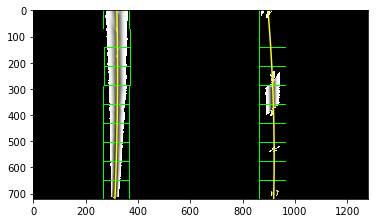

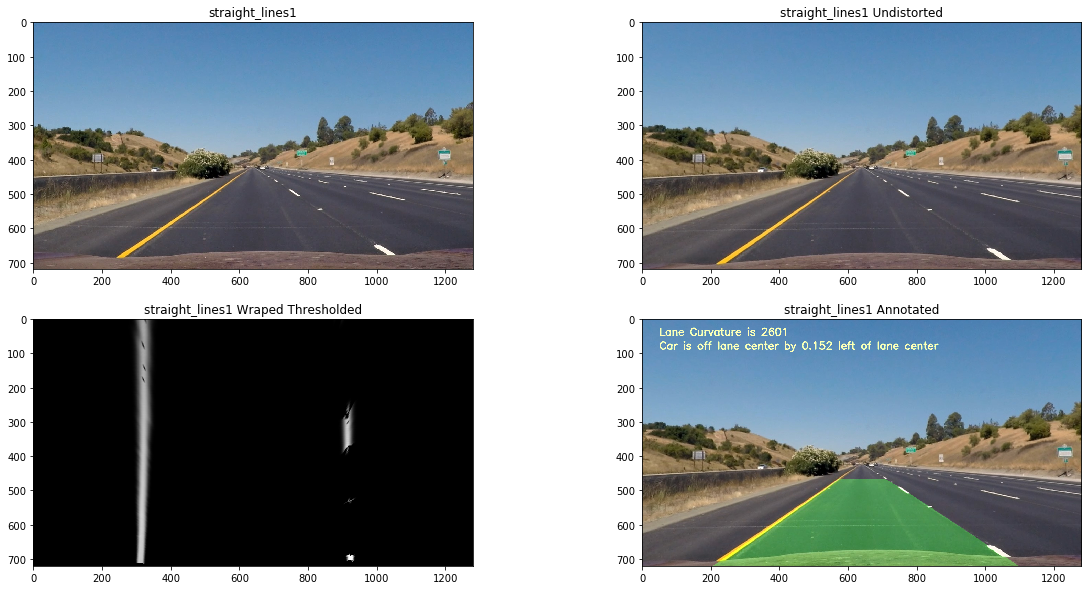

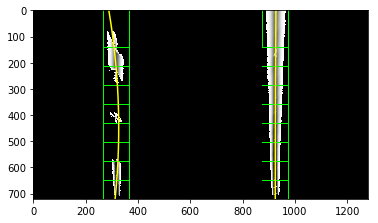

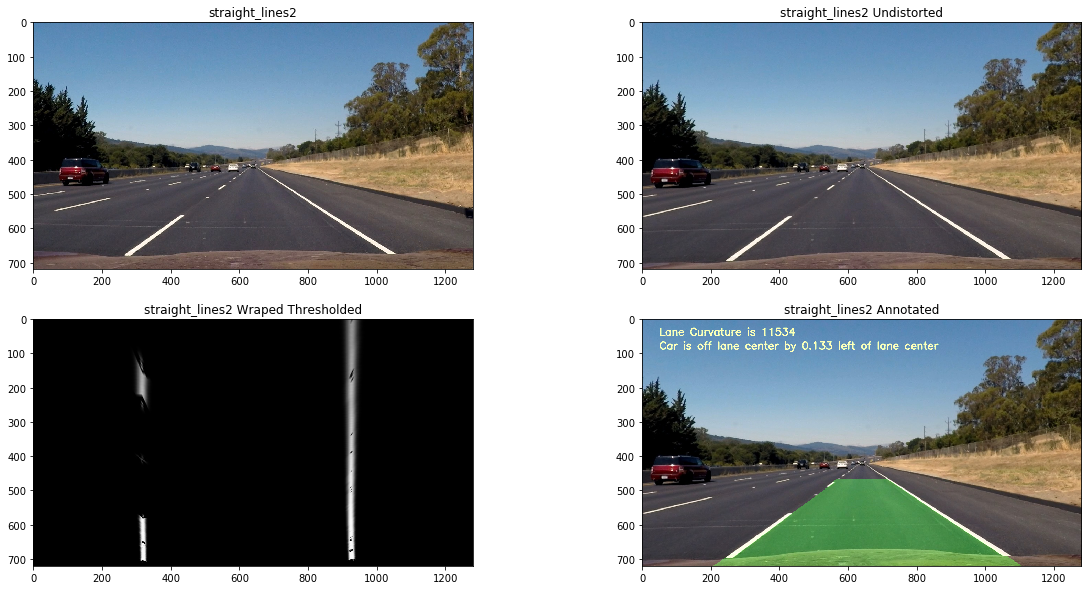

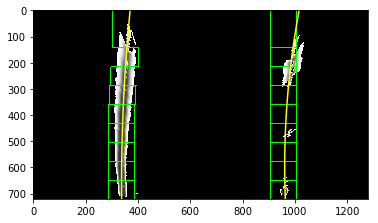

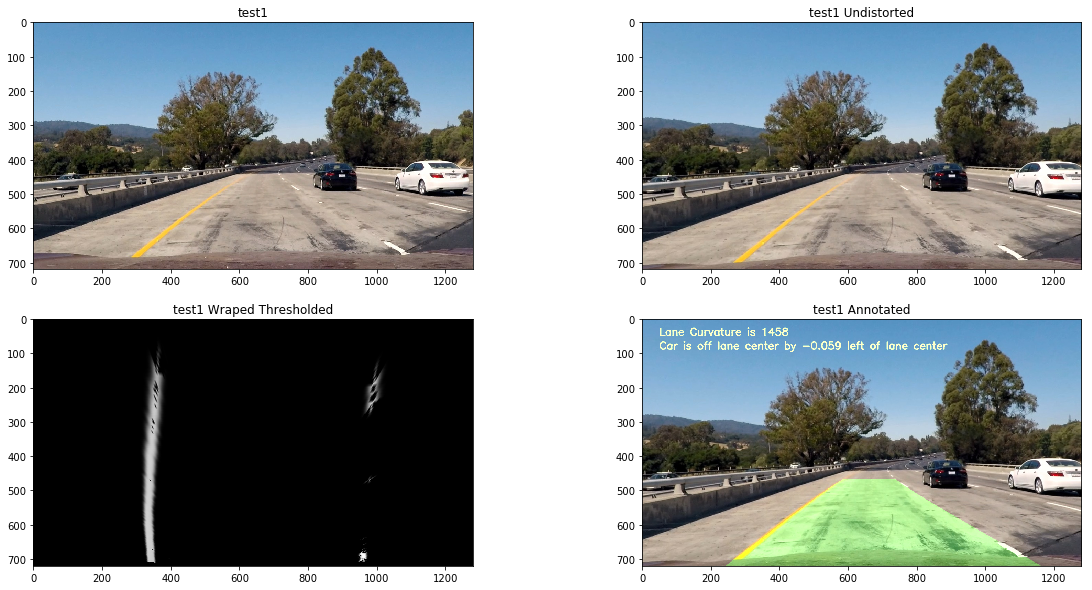

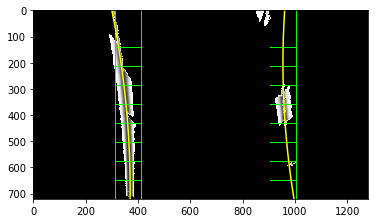

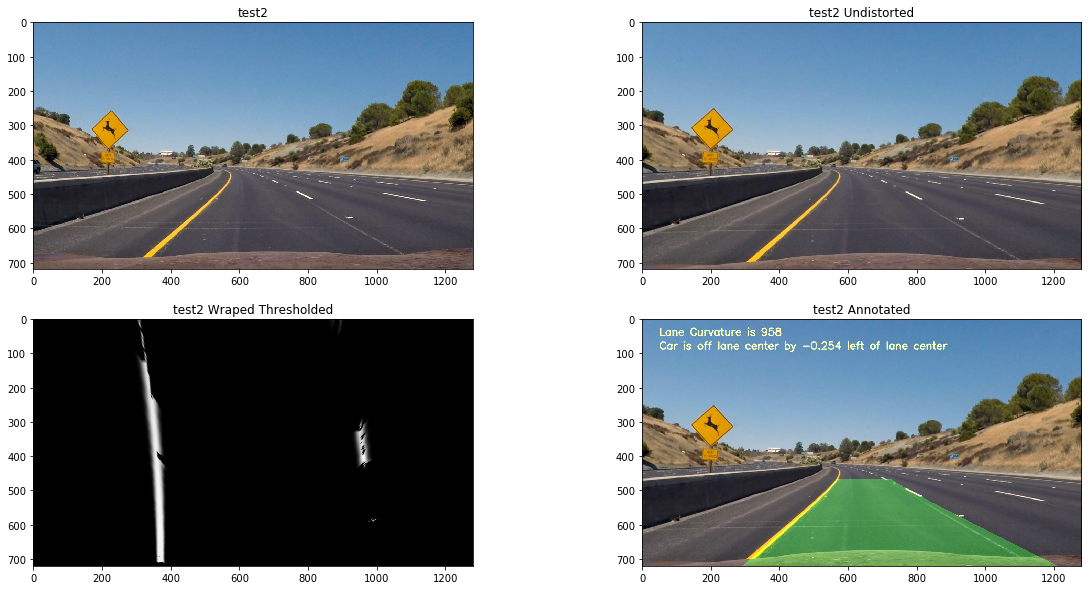

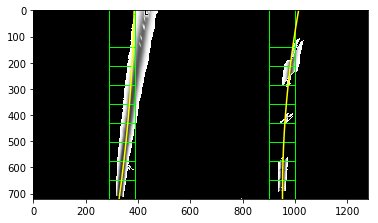

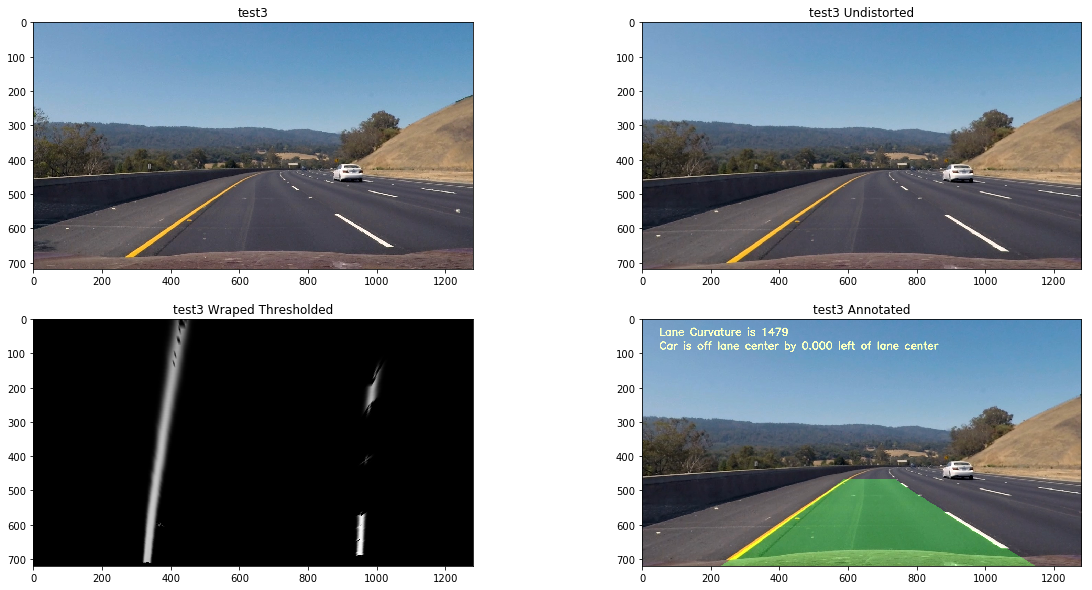

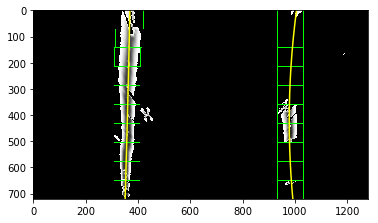

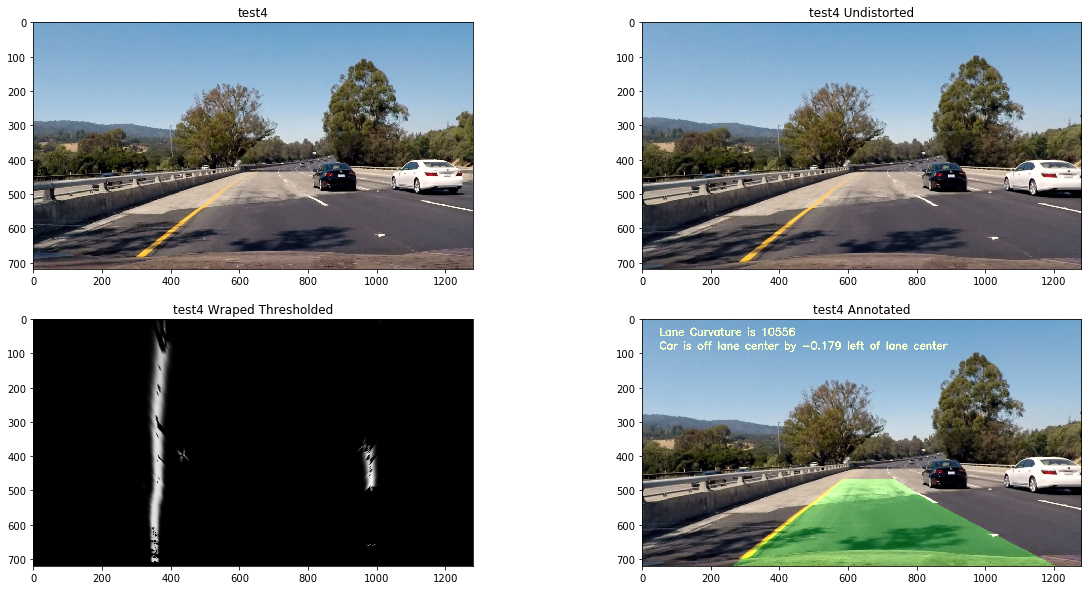

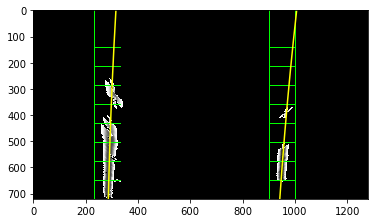

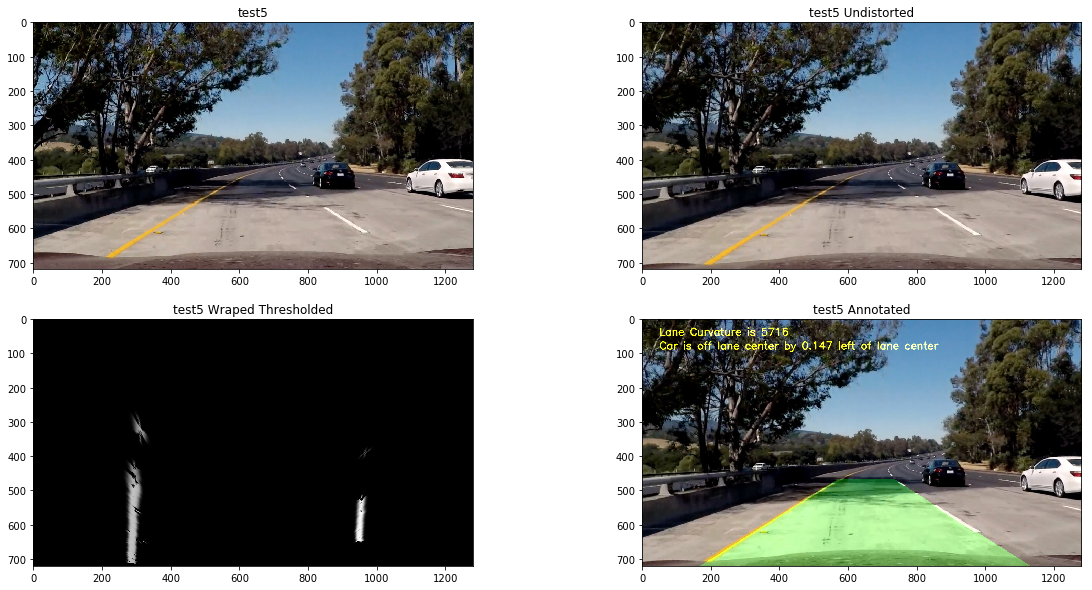

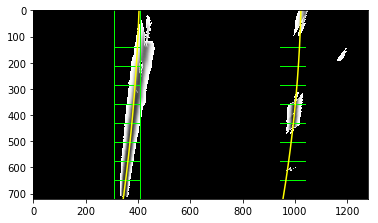

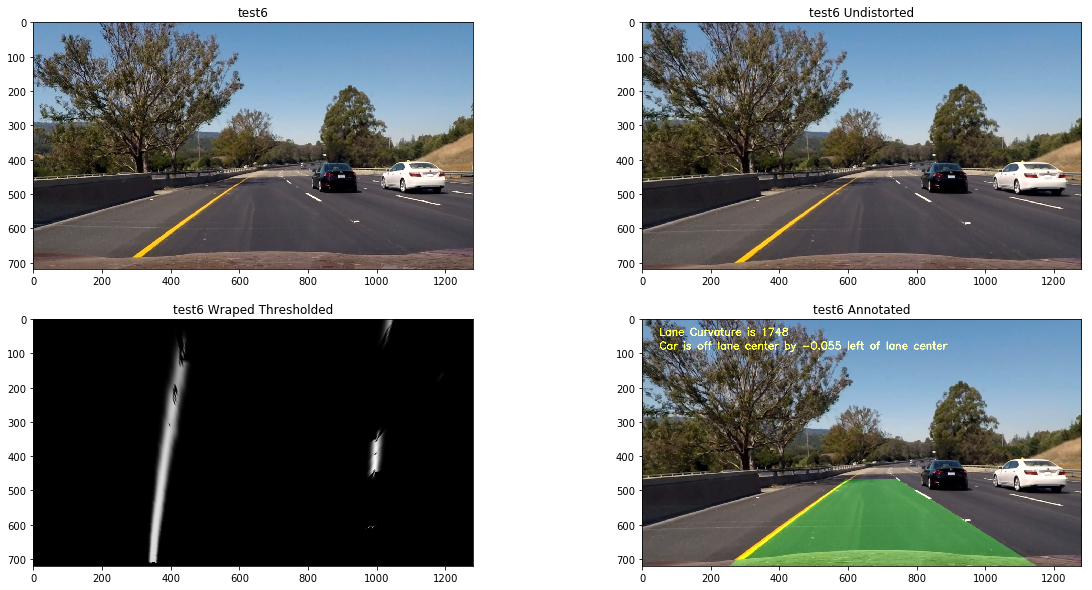

In [14]:
TestimagesPaths = os.listdir("test_images/")

TestImages = CollectImages("test_images/", TestimagesPaths)

for image, label in TestImages:
    img_h = image.shape[0]
    img_w = image.shape[1]

    top_left     = [img_w * 0.45, img_h * 0.6]
    top_right    = [img_w * 0.57, img_h * 0.6]
    bottom_left  = [img_w * 0.1, img_h]
    bottom_right = [img_w * 0.97, img_h]
    verticies = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    blurKernelSize  = 7
    SobelKernelSize = 15
    SobelThresholds = [0, 25, 40, 70]
    
    #Preprocess an image to generate an undistorted image.
    UndistortedImg = UnDistortImages(image)
    
    #Preprocess an image to generate a warped, thresholded image.
    processedImage = Extract_feature_from_image(UndistortedImg, label, blurKernelSize, SobelKernelSize, SobelThresholds, verticies, False)
    
    #Calculate histogram of the preprocessed image.
    histogram = np.sum(processedImage[processedImage.shape[0]//2:,:], axis=0)
    
    # Choose the number of sliding windows
    nwindows = 10
    #define the size on both sides of the lane center to be searched for lane line
    margin = 50
    #Number of pixels to be found on one side to update the window center
    activeThreshold = 4000
    
    annotatedImage = slidingWindowBlindSearch(processedImage, UndistortedImg, label, histogram, nwindows, margin, activeThreshold, True)
    
    images = [image, UndistortedImg, processedImage, annotatedImage]
    labels = [label, label+' Undistorted', label+' Wraped Thresholded', label+' Annotated']
    pltImages(images, labels, nrows = 2, ncols = 2, isgray = True)

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def slidingWindowBlindSearch_video(image, hist, winCnt, margin, thrshld, visualize = False):
    img_h = image.shape[0]
    img_w = image.shape[1]

    #divide the histogram to two halfs each one contains one lane (right/left)
    midpoint    = np.int(hist.shape[0]/2)
    #leftx_base represent the center of the left lane peak in histogram
    leftx_base  = np.argmax(histogram[:midpoint])
    #rightx_base represent the center of the right lane peak in histogram
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Calculate height of each window
    window_height = np.int(img_h/winCnt)

    #Identify postively thresholded pixels in image
    actvpxl  = image.nonzero()
    #nonzero return a tupple of arrays representing the x and y cordintes of the non zero element in the matrix
    Xactvpxl = actvpxl[1]
    Yactvpxl = actvpxl[0]

    leftx  = []
    lefty  = []
    rightx = []
    righty = []

    win_top    = img_h - window_height
    win_bottom = img_h

    for window in range(winCnt):
        #Calculate window position in the image
        lwin_left  = leftx_base - margin
        lwin_right = leftx_base + margin

        rwin_left  = rightx_base - margin
        rwin_right = rightx_base + margin

        #below five lines are inspired from https://stackoverflow.com/questions/5642457/how-does-python-numpy-where-work
        #using lwin_left < Xactvpxl < lwin_right failed because numpy doesnt support comparing two binary arrays
        lwinXactvpxl = (lwin_left < Xactvpxl) & (Xactvpxl < lwin_right)
        rwinXactvpxl = (rwin_left < Xactvpxl) & (Xactvpxl < rwin_right)
        winYactvpxl  = (win_top < Yactvpxl)   & (Yactvpxl < win_bottom)

        lwinactvpxlidx = np.where(lwinXactvpxl & winYactvpxl)[0]
        rwinactvpxlidx = np.where(rwinXactvpxl & winYactvpxl)[0]

        lwinactvpxl = Xactvpxl[lwinactvpxlidx]
        rwinactvpxl = Xactvpxl[rwinactvpxlidx]

        leftx.append(lwinactvpxl)
        lefty.append(Yactvpxl[lwinactvpxlidx])
        rightx.append(rwinactvpxl)
        righty.append(Yactvpxl[rwinactvpxlidx])

        # If you found > minpix pixels, recenter next window on their mean position
        if len(lwinactvpxlidx) > thrshld:
            leftx_base = np.int(np.mean(lwinactvpxl))

        if len(rwinactvpxlidx) > thrshld:
            rightx_base = np.int(np.mean(rwinactvpxl))

        win_top    -= window_height
        win_bottom -= window_height

    leftx  = np.concatenate(leftx)
    lefty  = np.concatenate(lefty)
    rightx = np.concatenate(rightx)
    righty = np.concatenate(righty)

    left_fit  = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #calculate curvature
    y_eval = np.max(lefty)
    
    ym_per_pix = 30/720  # meters per pixel in y dimension
    
    leftlane   = left_fit[0]*img_h**2 + left_fit[1]*img_h + left_fit[2]
    rightlane  = right_fit[0]*img_h**2 + right_fit[1]*img_h + right_fit[2]
    
    lanewidth  = rightlane - leftlane
    
    xm_per_pix = 3.7/lanewidth # meters per pixel in x dimension
    
    #convert from pixel space to real world space
    left_fit_cr  = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Caclculate car offset from the lane center
    lanecenter = int((leftlane + rightlane) / 2)

    #camera is assumed to be in the middle of the car
    offset = ((img_w / 2) - lanecenter)  * xm_per_pix
    
    return (left_fit, right_fit, left_curverad, right_curverad, offset)

In [17]:
def drawLaneLines(image, polyCoeff, curvature, offset):
    left_fit, right_fit = polyCoeff

    # Create an image to draw the lane on
    text_canvas = np.zeros_like(image).astype(np.uint8)
    color_warp  = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty      = np.linspace(0, img_h-1, img_h)

    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left   = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right  = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarplane = cv2.warpPerspective(color_warp, MInv, (img_w, img_h))
    font = cv2.FONT_HERSHEY_SIMPLEX
    buffer = 'Lane Curvature is ' + str(curvature)
    cv2.putText(text_canvas, buffer, (50,50), font, 1,(255,255,0), 2, cv2.LINE_AA)
    
    buffer = ("Car is {:.3f} left of lane center".format(offset))
    cv2.putText(text_canvas, buffer, (50,90), font, 1,(255,255,0), 2, cv2.LINE_AA)
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarplane, 0.3, 0)
    result = cv2.addWeighted(result, 1, text_canvas, 1, 0)
    
    return result

In [18]:
queue = []
queue_size = 8

def process_frame(image):
    img_h = image.shape[0]
    img_w = image.shape[1]
    
    top_left     = [img_w * 0.45, img_h * 0.6]
    top_right    = [img_w * 0.57, img_h * 0.6]
    bottom_left  = [img_w * 0.1, img_h]
    bottom_right = [img_w * 0.97, img_h]
    verticies = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    blurKernelSize  = 7
    SobelKernelSize = 15
    SobelThresholds = [0, 25, 40, 70]
    
    #Preprocess an image to generate an undistorted image.
    UndistortedImg = UnDistortImages(image)
    
    #Preprocess an image to generate a warped, thresholded image.
    processedImage = Extract_feature_from_image(UndistortedImg, label, blurKernelSize, SobelKernelSize, SobelThresholds, verticies, False)
    
    #Calculate histogram of the preprocessed image.
    histogram = np.sum(processedImage[processedImage.shape[0]//2:,:], axis=0)
    
    # Choose the number of sliding windows
    nwindows = 5
    #define the size on both sides of the lane center to be searched for lane line
    margin = 50
    #Number of pixels to be found on one side to update the window center
    activeThreshold = 2000
    
    polyCoeff = slidingWindowBlindSearch_video(processedImage, histogram, nwindows, margin, activeThreshold)
    
    left_fit, right_fit, llcurv, rlcurv, offset = polyCoeff
    
    #Sanity check that the two lines curvature is not very far
    rlcurv_min = rlcurv * 0.1
    rlcurv_max = rlcurv * 2.5

    if rlcurv_min < llcurv < rlcurv_max:
        #curvature is withing acceptable range
        curvature = min(llcurv, rlcurv)
        
        queue.append((polyCoeff, curvature))
        if(len(queue) > queue_size):
            queue.pop(0)

    avgleft_fit  = []
    avgright_fit = []
    avgcurvature = 0
    avgoffset    = 0
    
    for elm in queue:
        polyCoeff, curvature = elm
        left_fit, right_fit, left_curverad, right_curverad, offset = polyCoeff
        avgleft_fit.append(left_fit)
        avgright_fit.append(right_fit)
        avgcurvature += curvature
        avgoffset    += offset

    avgleft_fit  = [sum(i) for i in zip(*avgleft_fit)]
    avgleft_fit  = [i / len(queue) for i in avgleft_fit]
    avgright_fit = [sum(i) for i in zip(*avgright_fit)]
    avgright_fit = [i / len(queue) for i in avgright_fit]
    avgcurvature /= len(queue)
    avgoffset    /= len(queue)
    
    annotatedImage = drawLaneLines(UndistortedImg, (avgleft_fit, avgright_fit), int(avgcurvature), avgoffset)

    '''images = [image, UndistortedImg, processedImage, annotatedImage]
    labels = ['orig', ' Undistorted', ' Wraped Thresholded', ' Annotated']
    pltImages(images, labels, nrows = 2, ncols = 2, isgray = True)'''
    return annotatedImage

In [19]:
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_frame)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:05<00:00,  6.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 6s


In [20]:
HTML("""
<video width="640" height="340" controls>
  <source src="{0}">
</video>
""".format(project_output))